In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report
import joblib
from scipy.stats import mode


import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load dataset
train = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s4e11/sample_submission.csv")

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                    

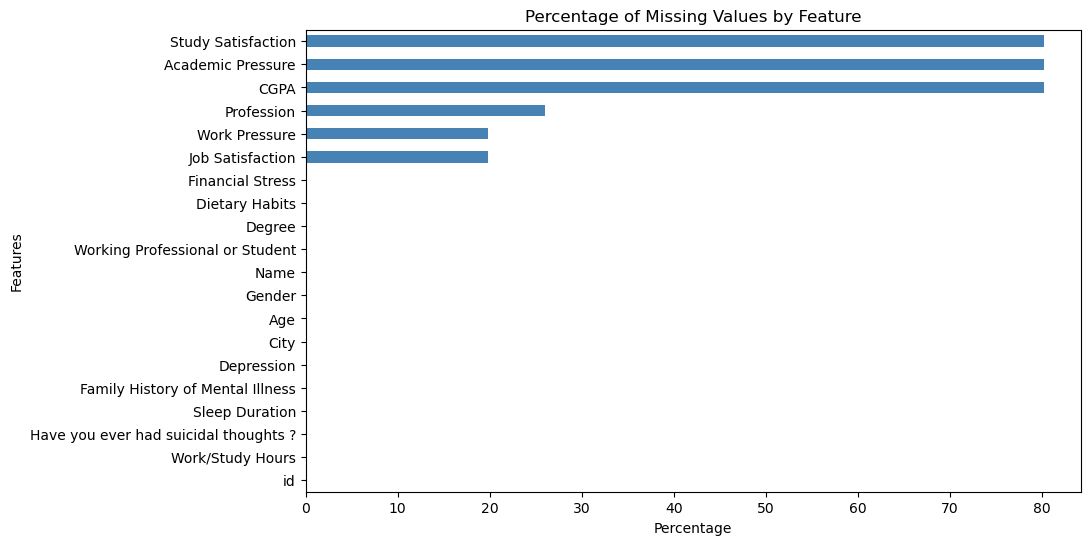

In [ ]:
# Understand the data structure and missing values
print("Dataset Overview:")
print(df_train.info())
print("\nMissing Values Overview:")
missing_values = df_train.isna().sum().sort_values(ascending=False)
print(missing_values)

# Visualize missing values
plt.figure(figsize=(10, 6))
missing_percent = (df_train.isnull().sum() / len(df_train)) * 100
missing_percent.sort_values(ascending=True).plot(kind="barh", color="steelblue")
plt.title("Percentage of Missing Values by Feature")
plt.xlabel("Percentage")
plt.ylabel("Features")
plt.show()

In [ ]:
# Data preprocessing function for feature encoding and missing value handling
def preprocess_data(data):
    # Convert categorical columns to numeric using label encoding
    for col in data.select_dtypes(include=["object", "category"]).columns:
        data[col] = data[col].astype("category").cat.codes

    # Handle missing values
    for col in data.select_dtypes(include=["float64", "int64"]).columns:
        if data[col].isnull().sum() > 0:
            data[col] = data[col].fillna(data[col].median())  # Fill numeric with median

    return data

df_train_cleaned = preprocess_data(df_train)
df_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  int16  
 2   Gender                                 140700 non-null  int8   
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  int8   
 5   Working Professional or Student        140700 non-null  int8   
 6   Profession                             140700 non-null  int8   
 7   Academic Pressure                      140700 non-null  float64
 8   Work Pressure                          140700 non-null  float64
 9   CGPA                                   140700 non-null  float64
 10  Study Satisfaction                     140700 non-null  

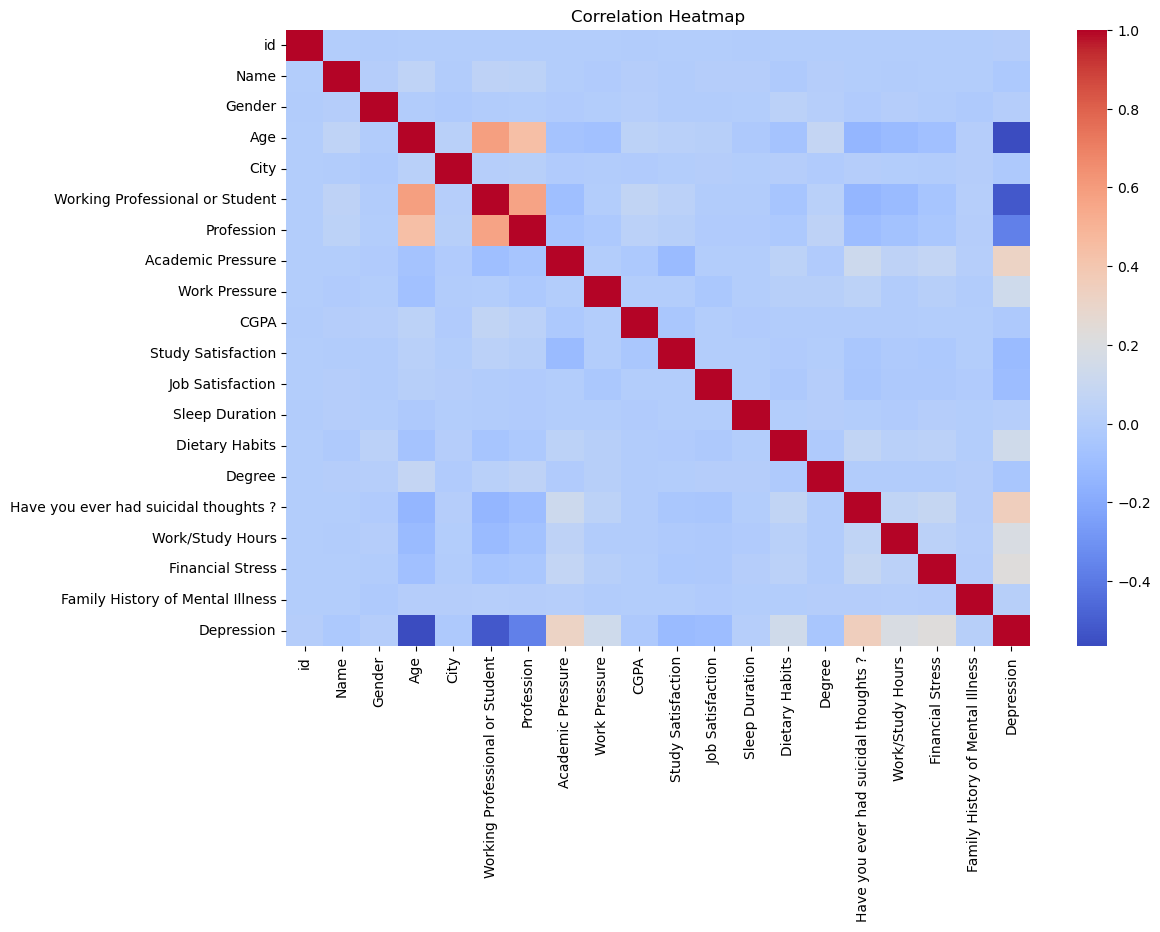

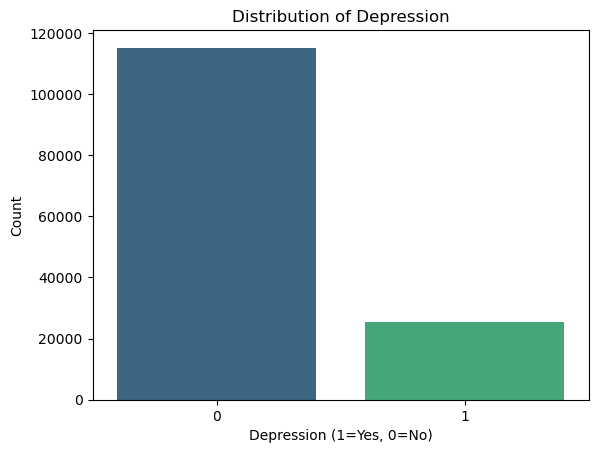

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_train_cleaned.corr(), annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Distribution of Depression
sns.countplot(x="Depression", data=df_train_cleaned, palette="viridis")
plt.title("Distribution of Depression")
plt.xlabel("Depression (1=Yes, 0=No)")
plt.ylabel("Count")
plt.show()

# Pairplot to explore relationships (optional for small datasets)
# sns.pairplot(df_train_cleaned, hue="Depression", diag_kind="kde")

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top features correlated with Depression
X = df_train_cleaned.drop("Depression", axis=1)
y = df_train_cleaned["Depression"]

selector = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features
X_selected = selector.fit_transform(X, y)

# Display selected features
selected_features = X.columns[selector.get_support()]
print("Top 10 Features:")
print(selected_features)

Top 10 Features:
Index(['Age', 'Working Professional or Student', 'Profession',
       'Academic Pressure', 'Work Pressure', 'Study Satisfaction',
       'Dietary Habits', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress'],
      dtype='object')


In [ ]:
def train_baseline_models(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define models
    models = {
        "Random Forest": RandomForestClassifier(random_state=42),
        "Logistic Regression": LogisticRegression(random_state=42, max_iter=500),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        "CatBoostClassifier": CatBoostClassifier(verbose=0),
        "AdaBoostClassifier": AdaBoostClassifier(),
        "KNeighborsClassifier": KNeighborsClassifier()
    }

    # Dictionaries to store scores
    train_accuracies = {}
    test_accuracies = {}
    feature_importances = {}

    # Train and evaluate each model
    for model_name, model in models.items():
        try:
            # Train the model
            model.fit(X_train, y_train)

            # Predict on training data
            y_train_pred = model.predict(X_train)
            train_accuracies[model_name] = accuracy_score(y_train, y_train_pred)

            # Predict on test data
            y_test_pred = model.predict(X_test)
            test_accuracies[model_name] = accuracy_score(y_test, y_test_pred)
            print(f"Classification Report: {model_name}")
            print(classification_report(y_test, y_test_pred))

            # Store feature importance if available
            if hasattr(model, "feature_importances_"):
                feature_importances[model_name] = model.feature_importances_
            elif hasattr(model, "coef_"):
                feature_importances[model_name] = model.coef_[0]

        except Exception as e:
            print(f"Model {model_name} failed to train: {e}")

    return train_accuracies, test_accuracies, feature_importances

In [ ]:
def plot_model_scores(train_scores, test_scores, title="Model Accuracy Comparison"):

    # Sort models by test accuracy in descending order
    sorted_models = sorted(test_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    model_names = [model[0] for model in sorted_models]

    # Extract corresponding training and test scores
    train_accuracies = [train_scores[model] for model in model_names]
    test_accuracies = [test_scores[model] for model in model_names]

    # Create the bar plot
    x = range(len(model_names))
    bar_width = 0.4

    plt.figure(figsize=(12, 8))
    plt.barh(x, train_accuracies, height=bar_width, color="lightblue", label="Train Accuracy")
    plt.barh([p + bar_width for p in x], test_accuracies, height=bar_width, color="orange", label="Test Accuracy")

    plt.xlabel("Accuracy")
    plt.ylabel("Model")
    plt.yticks([p + bar_width / 2 for p in x], model_names)
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis for readability
    plt.legend()

    # Annotate bars with accuracy values
    for i, (train_acc, test_acc) in enumerate(zip(train_accuracies, test_accuracies)):
        plt.text(train_acc - 0.05, i, f"{train_acc * 100:.2f}%", va="center", ha="right", color="black")
        plt.text(test_acc - 0.05, i + bar_width, f"{test_acc * 100:.2f}%", va="center", ha="right", color="black")

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_feature_importance(feature_importance, model_name, X_columns):
    indices = np.argsort(feature_importance)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importances ({model_name})")
    plt.bar(range(len(indices)), feature_importance[indices], align="center", color="skyblue")
    plt.xticks(range(len(indices)), [X_columns[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_all_feature_importances(feature_importances, X_columns):
    # Iterate through each model's feature importances
    for model_name, importance in feature_importances.items():
        if importance is not None:
            plot_feature_importance(importance, model_name, X_columns)
        else:
            print(f"Model {model_name} does not provide feature importance.")

In [ ]:
X = df_train_cleaned.drop("Depression", axis=1)
y = df_train_cleaned["Depression"]

# Train baseline models and get accuracy scores
train_scores, test_scores, feature_importances = train_baseline_models(X, y)

Classification Report: Random Forest
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     22986
           1       0.84      0.80      0.82      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.88      0.89     28140
weighted avg       0.93      0.94      0.94     28140

Classification Report: Logistic Regression
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     22986
           1       0.72      0.64      0.68      5154

    accuracy                           0.89     28140
   macro avg       0.82      0.79      0.81     28140
weighted avg       0.89      0.89      0.89     28140

Classification Report: Gradient Boosting
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22986
           1       0.85      0.81      0.83      5154

    accuracy                           0.94     28140
   macr

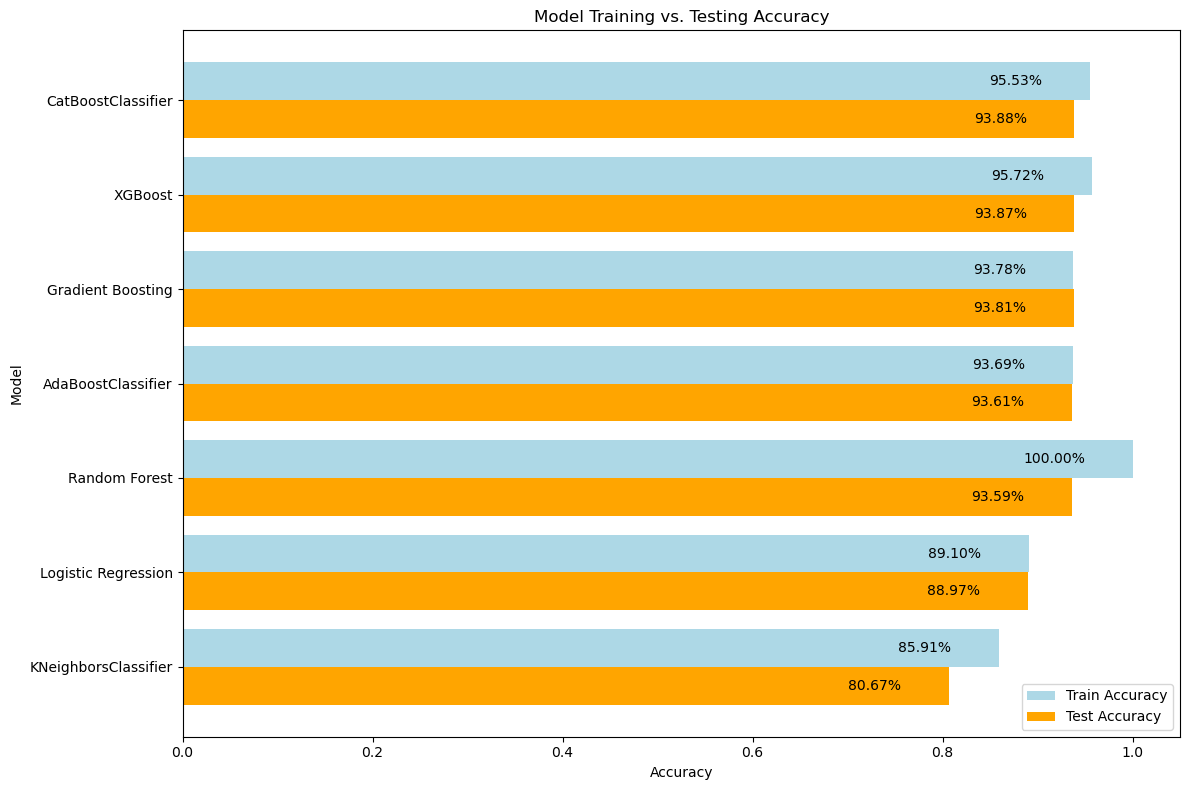

In [ ]:
plot_model_scores(train_scores, test_scores, title="Model Training vs. Testing Accuracy")

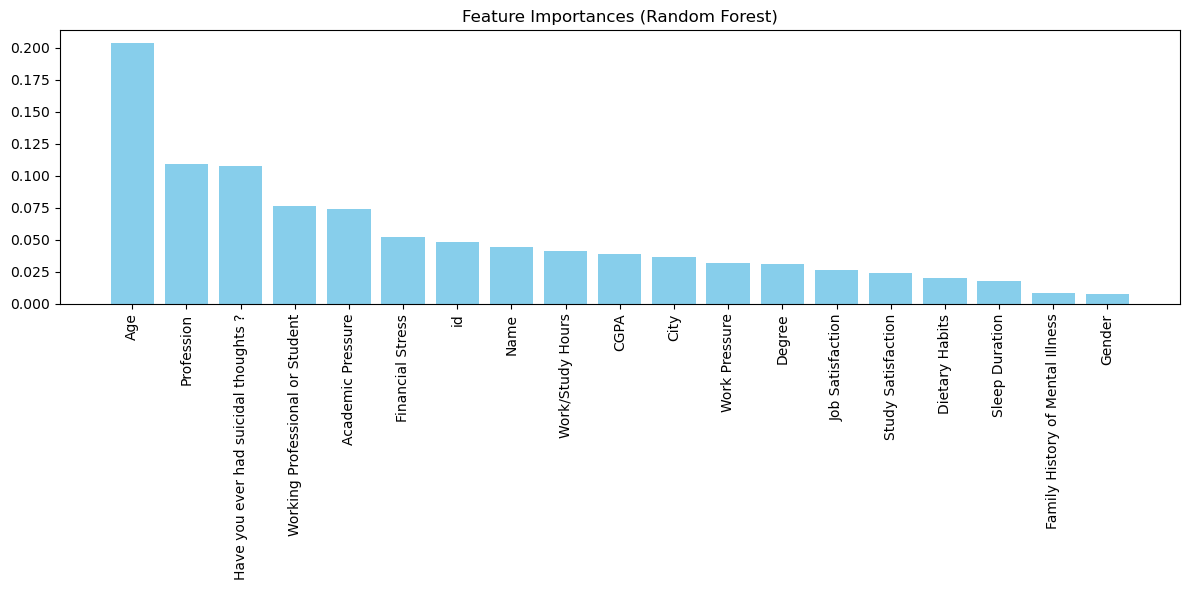

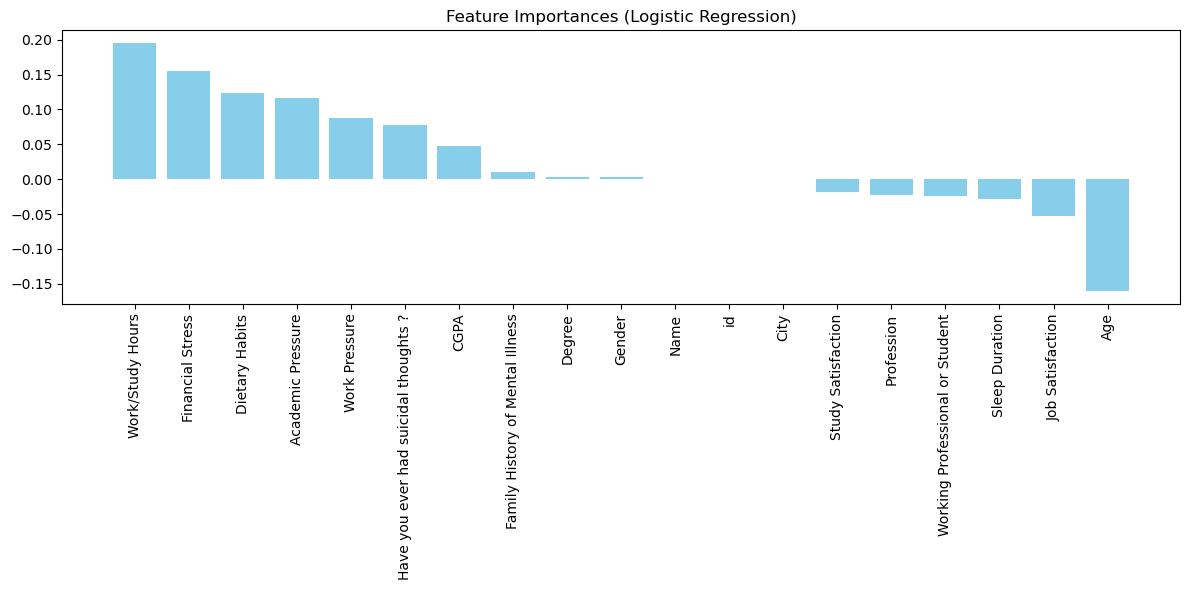

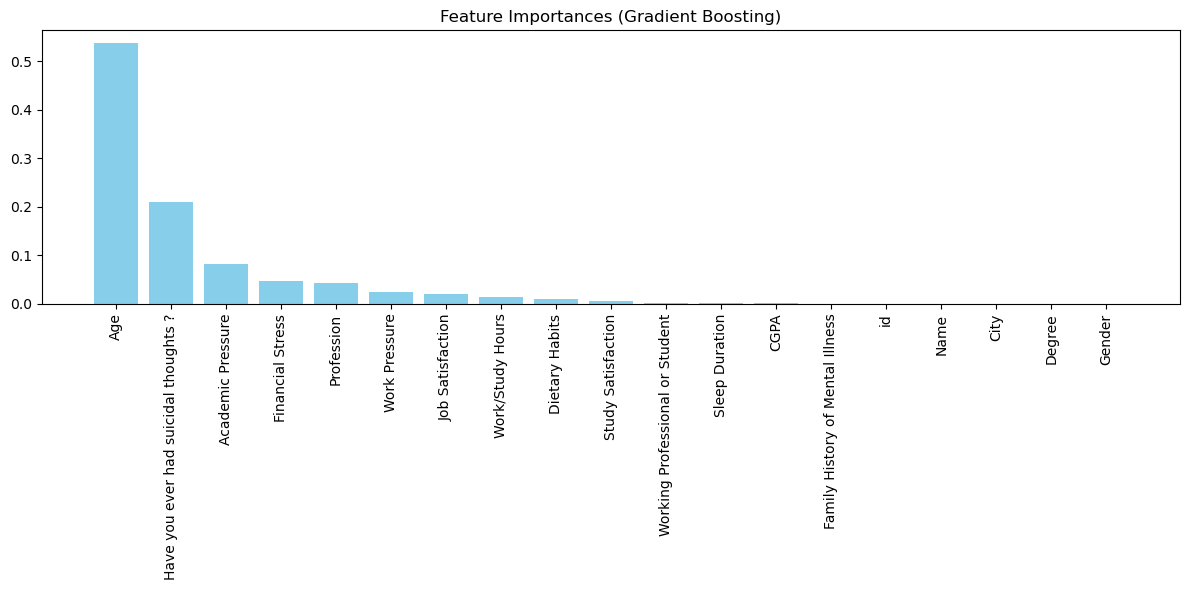

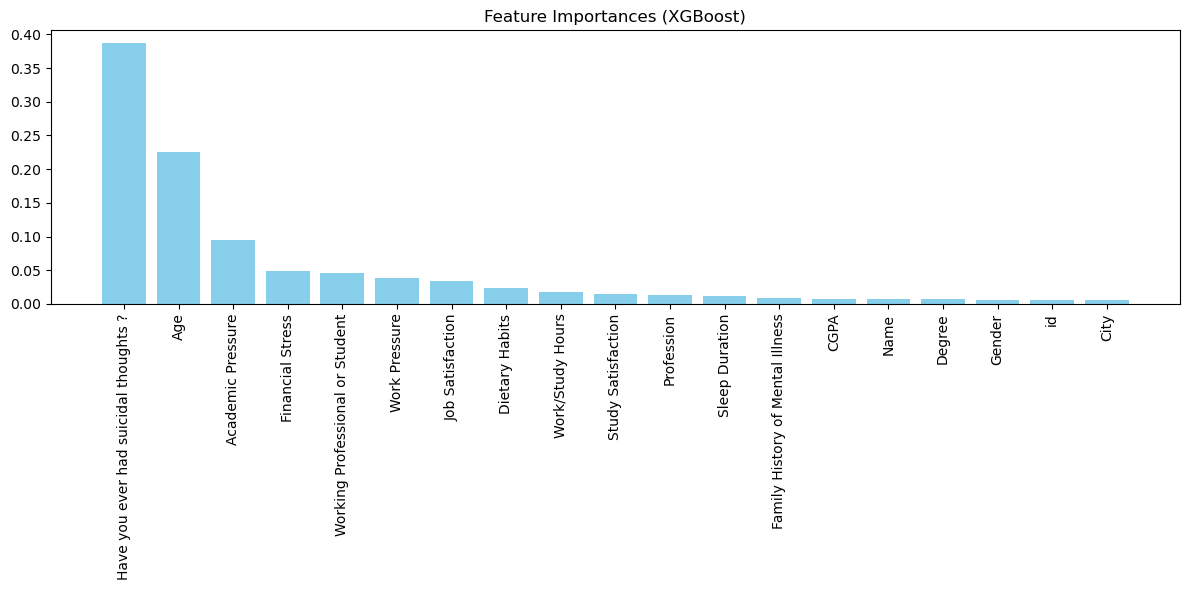

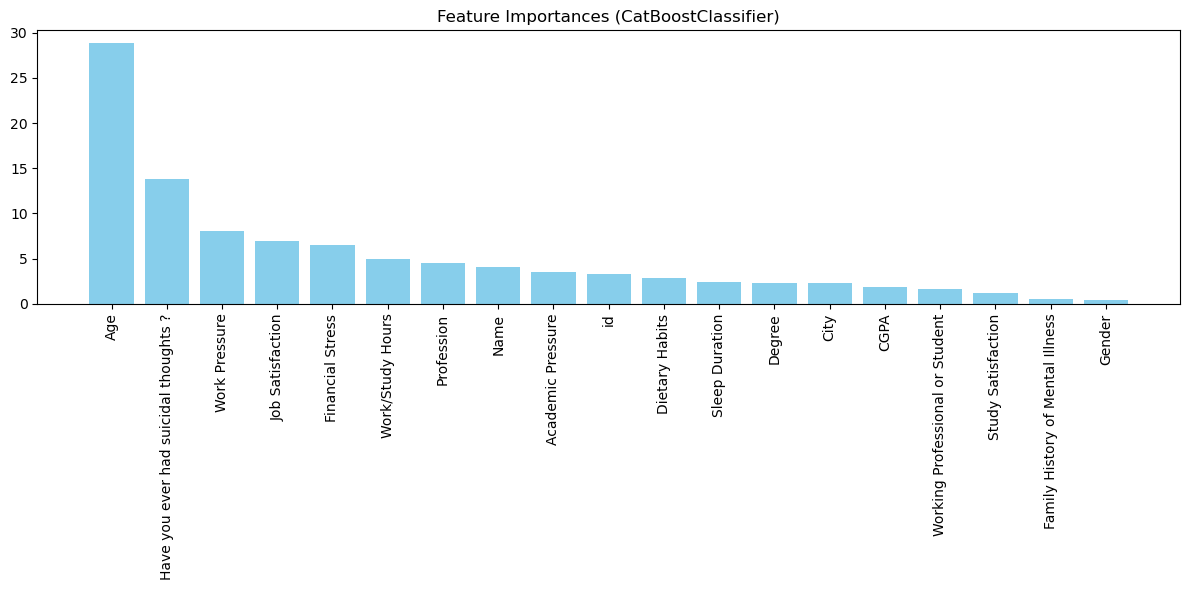

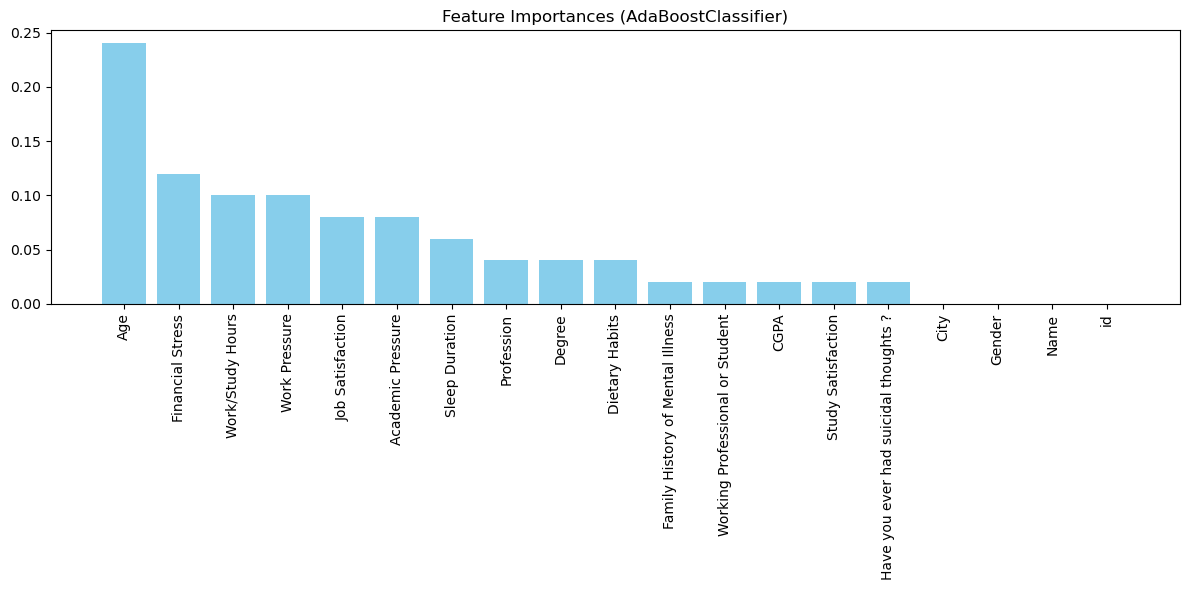

In [ ]:
# Plot feature importance for each model
plot_all_feature_importances(feature_importances, X.columns)

In [ ]:
X = df_train_cleaned.drop("Depression", axis=1)
y = df_train_cleaned["Depression"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
cat_grid = {
    'iterations': [100, 200, 500, 1000],  # Number of boosting iterations
    'learning_rate': [0.01, 0.03, 0.1, 0.2],  # Step size shrinkage
    'depth': [4, 6, 8, 10],  # Depth of the tree
    'l2_leaf_reg': [1, 3, 5, 7],  # L2 regularization
    'bagging_temperature': [0, 1, 2, 3],  # Controls subsampling
    'random_strength': [1, 5, 10, 20],  # Noise for splitting score
    'max_bin': [200, 300, 500],  # Maximum number of bins for discretizing continuous features
    'scale_pos_weight': [1, 2, 5],  # Class balancing for imbalanced datasets
}

# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(verbose=0)

# Create the RandomizedSearchCV object
cat_model = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=cat_grid,
    n_iter=100,  # Number of parameter settings to sample
    scoring='accuracy',  # Evaluation metric
    cv=5,  # Number of cross-validation folds
    random_state=42,
    #n_jobs=,  # Use all available cores
    verbose=3
)

# Fit RandomizedSearchCV
cat_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END bagging_temperature=1, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1, max_bin=500, random_strength=5, scale_pos_weight=1;, score=0.935 total time=  25.4s
[CV 2/5] END bagging_temperature=1, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1, max_bin=500, random_strength=5, scale_pos_weight=1;, score=0.937 total time=  25.4s
[CV 3/5] END bagging_temperature=1, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1, max_bin=500, random_strength=5, scale_pos_weight=1;, score=0.938 total time=  22.8s
[CV 4/5] END bagging_temperature=1, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1, max_bin=500, random_strength=5, scale_pos_weight=1;, score=0.939 total time=  21.0s
[CV 5/5] END bagging_temperature=1, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1, max_bin=500, random_strength=5, scale_pos_weight=1;, score=0.936 total time=  21.8s
[CV 1/5] END bagging_temperature=0, d

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001EF99C068E0>,
                   n_iter=100,
                   param_distributions={'bagging_temperature': [0, 1, 2, 3],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [100, 200, 500, 1000],
                                        'l2_leaf_reg': [1, 3, 5, 7],
                                        'learning_rate': [0.01, 0.03, 0.1, 0.2],
                                        'max_bin': [200, 300, 500],
                                        'random_strength': [1, 5, 10, 20],
                                        'scale_pos_weight': [1, 2, 5]},
                   random_state=42, scoring='accuracy', verbose=3)

In [ ]:
# 1. Train and Save the Model Locally
# Retrieve the best parameters
best_params = cat_model.best_params_
print("Best Parameters:", best_params)

# Initialize CatBoostClassifier with the best parameters
best_catboost_model = CatBoostClassifier(**best_params, verbose=0)

# Perform cross-validation to evaluate the model
cv_scores = cross_val_score(best_catboost_model, X_train, y_train, cv=5, scoring='accuracy')

# Output cross-validation results
print("Cross-validation accuracy scores:", cv_scores)
print("Mean cross-validation accuracy:", cv_scores.mean())

# Fit the model on the entire training data
best_catboost_model.fit(X_train, y_train)

# Save the trained model locally
model_filename = "best_catboost.cbm"
best_catboost_model.save_model(model_filename)
print(f"Model saved locally as {model_filename}")

Best Parameters: {'scale_pos_weight': 1, 'random_strength': 1, 'max_bin': 200, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 4, 'bagging_temperature': 1}
Cross-validation accuracy scores: [0.93705579 0.9419865  0.94074271 0.94140903 0.93834399]
Mean cross-validation accuracy: 0.939907604832978
Model saved locally as best_catboost.cbm


In [ ]:
test_df_preprocessed = preprocess_data(df_test)

In [ ]:
# Path to the CatBoost model file
catboost_model_path = "best_catboost.cbm"

# Load the CatBoost model
catboost_model = CatBoostClassifier()
catboost_model.load_model(catboost_model_path)

In [ ]:
test_preds_cat_model = catboost_model.predict(test_df_preprocessed)
test_df_preprocessed.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,140700,288,1,53.0,67,1,27,3.0,2.0,7.80,3.0,5.0,25,12,53,0,9.0,3.0,1
1,140701,279,0,58.0,25,1,19,3.0,2.0,7.80,3.0,4.0,25,12,16,0,6.0,4.0,0
2,140702,365,1,53.0,21,1,56,3.0,4.0,7.80,3.0,1.0,16,12,12,1,12.0,4.0,0
3,140703,191,0,23.0,47,0,-1,5.0,3.0,6.84,1.0,3.0,27,12,35,1,10.0,4.0,0
4,140704,285,1,47.0,22,1,56,3.0,5.0,7.80,3.0,5.0,16,12,28,1,3.0,4.0,0


In [ ]:
# Create DataFrame compatible with Kaggle submission requirements
pred_df = pd.DataFrame()
pred_df["id"] = test_df_preprocessed["id"]
pred_df["Depression"] = test_preds_cat_model

# Display the updated DataFrame
print(pred_df.sample(5))

           id  Depression
29743  170443           0
63117  203817           0
88834  229534           1
49714  190414           0
9586   150286           0


In [ ]:
pred_df.to_csv('test_preds_cat.csv', index=False)

In [ ]:
X = df_train_cleaned.drop("Depression", axis=1)
y = df_train_cleaned["Depression"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
hist_grid = {
    'learning_rate': [0.01, 0.03, 0.1, 0.2],  # Step size shrinkage
    'max_iter': [100, 200, 500],  # Number of boosting iterations
    'max_depth': [3, 5, 7, 10],  # Maximum depth of trees
    'l2_regularization': [0.1, 1, 10],  # L2 regularization
    'max_bins': [255, 512],  # Number of bins for discretizing continuous features
    'min_samples_leaf': [10, 20, 50],  # Minimum samples per leaf
    'scoring': ['loss', 'accuracy'],  # Scoring metric
}

# Initialize HistGradientBoostingClassifier
hist_model = HistGradientBoostingClassifier(verbose=0)

# Create the RandomizedSearchCV object
hist_model_search = RandomizedSearchCV(
    estimator=hist_model,
    param_distributions=hist_grid,
    n_iter=100,  # Number of parameter settings to sample
    scoring='accuracy',  # Evaluation metric
    cv=5,  # Number of cross-validation folds
    random_state=42,
    verbose=3,
    #n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV
hist_model_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END l2_regularization=1, learning_rate=0.01, max_bins=255, max_depth=5, max_iter=100, min_samples_leaf=50, scoring=accuracy;, score=0.819 total time=   0.3s
[CV 2/5] END l2_regularization=1, learning_rate=0.01, max_bins=255, max_depth=5, max_iter=100, min_samples_leaf=50, scoring=accuracy;, score=0.819 total time=   0.3s
[CV 3/5] END l2_regularization=1, learning_rate=0.01, max_bins=255, max_depth=5, max_iter=100, min_samples_leaf=50, scoring=accuracy;, score=0.819 total time=   0.3s
[CV 4/5] END l2_regularization=1, learning_rate=0.01, max_bins=255, max_depth=5, max_iter=100, min_samples_leaf=50, scoring=accuracy;, score=0.819 total time=   0.3s
[CV 5/5] END l2_regularization=1, learning_rate=0.01, max_bins=255, max_depth=5, max_iter=100, min_samples_leaf=50, scoring=accuracy;, score=0.819 total time=   0.3s
[CV 1/5] END l2_regularization=10, learning_rate=0.01, max_bins=255, max_depth=7, max_iter=500, min_samples

RandomizedSearchCV(cv=5, estimator=HistGradientBoostingClassifier(), n_iter=100,
                   param_distributions={'l2_regularization': [0.1, 1, 10],
                                        'learning_rate': [0.01, 0.03, 0.1, 0.2],
                                        'max_bins': [255, 512],
                                        'max_depth': [3, 5, 7, 10],
                                        'max_iter': [100, 200, 500],
                                        'min_samples_leaf': [10, 20, 50],
                                        'scoring': ['loss', 'accuracy']},
                   random_state=42, scoring='accuracy', verbose=3)

In [ ]:
# Retrieve the best parameters
best_params_hist = hist_model_search.best_params_
print("Best Parameters:", best_params_hist)

# Initialize HistGradientBoostingClassifier with the best parameters
best_hist_model = HistGradientBoostingClassifier(**best_params_hist)

# Perform cross-validation to evaluate the model
cv_scores_hist = cross_val_score(best_hist_model, X_train, y_train, cv=5, scoring='accuracy')

# Output cross-validation results
print("Cross-validation accuracy scores:", cv_scores_hist)
print("Mean cross-validation accuracy:", cv_scores_hist.mean())

# Fit the model on the entire training data
best_hist_model.fit(X_train, y_train)

# Save the trained model locally using joblib
model_filename = "best_hist_model.joblib"
joblib.dump(best_hist_model, model_filename)
print(f"Model saved locally as {model_filename}")

Best Parameters: {'scoring': 'loss', 'min_samples_leaf': 10, 'max_iter': 200, 'max_depth': 3, 'max_bins': 255, 'learning_rate': 0.2, 'l2_regularization': 0.1}
Cross-validation accuracy scores: [0.93678927 0.94074271 0.94038735 0.94052061 0.93847726]
Mean cross-validation accuracy: 0.9393834399431414
Model saved locally as best_hist_model.joblib


In [ ]:
# Path to the HistGradientBoosting model file
hist_model_path = "best_hist_model.joblib"

# Load the HistGradientBoosting model
hist_model = joblib.load(hist_model_path)

In [ ]:
test_preds_hist_model = hist_model.predict(test_df_preprocessed)

In [ ]:
# Create DataFrame compatible with Kaggle submission requirements
pred_df_hist = pd.DataFrame()
pred_df_hist["id"] = test_df_preprocessed["id"]
pred_df_hist["Depression"] = test_preds_hist_model

# Display the updated DataFrame
print(pred_df_hist.sample(5))

           id  Depression
85485  226185           0
55951  196651           0
70698  211398           0
48139  188839           0
87786  228486           0


In [ ]:
pred_df_hist.to_csv('test_preds_hist.csv', index=False)

In [ ]:
# Predictions on test_df_preprocessed
hist_preds_test = hist_model.predict(test_df_preprocessed)

# Predictions on test_df_preprocessed
hist_preds_new = hist_model.predict(test_df_preprocessed)

# Combine predictions into a single array
combined_preds = np.vstack((hist_preds_test, hist_preds_new)).T

# Perform voting (mode) for each row of combined predictions
final_preds = mode(combined_preds, axis=1).mode.flatten()

# Output the final predictions
final_preds[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1], dtype=int64)

In [ ]:
# Create DataFrame compatible with Kaggle submission requirements
pred_df_combined = pd.DataFrame()
pred_df_combined["id"] = test_df_preprocessed["id"]
pred_df_combined["Depression"] = final_preds

# Display the updated DataFrame
print(pred_df.sample(5))

           id  Depression
44132  184832           0
44017  184717           1
68220  208920           1
14935  155635           0
86129  226829           0


In [ ]:
pred_df_combined.to_csv('test_preds_hist_and_cat_combined.csv', index=False)